# DVF Grenoble — Régression linéaire (OLS)
Modélisation hédonique des prix immobiliers à Grenoble via régression linéaire (statsmodels/sklearn).
Objectifs: charger les données prétraitées, créer des variantes (log, standardisation), ajuster des modèles OLS, et visualiser performances/importance.

## Plan du notebook
1. Importations et configuration
2. Installation des dépendances
3. Chargement des données
4. Préparation des sous-ensembles
5. Analyse de corrélation
6. Transformations logarithmiques
7. Standardisation (z-score)
8. Jeux de données dérivés
9. Modélisation OLS (formule) et métriques
10. Visualisation: observé vs prédit et importance des variables
11. Conclusion

## 1. Importations et configuration

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler


## 2. Installation des dépendances
Installation de statsmodels si nécessaire.

In [14]:
%pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 3.0 MB/s  0:00:03m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]
Note: you may need to restart the kernel to use updated packages.


## 3. Chargement des données
Lecture du CSV prétraité (df_grenoble_vente.csv).

In [2]:
# Load Grenoble apartment CSV from project folder
from pathlib import Path
candidates = [
    Path('../DataPreprocessing/PreprocessedData/df_grenoble_vente.csv'),
    Path('DataPreprocessing/PreprocessedData/df_grenoble_vente.csv'),
    Path('projet_dvf/DataPreprocessing/PreprocessedData/df_grenoble_vente.csv'),
]
csv_path = next((p for p in candidates if p.exists()), None)
if csv_path is None:
    tried = [str((Path.cwd()/p).resolve()) if not p.is_absolute() else str(p) for p in candidates]
    raise FileNotFoundError(f'Missing file. Tried: {tried}')
df = pd.read_csv(csv_path)
print(f'Loaded {len(df):,} rows and {len(df.columns)} columns from {csv_path}')
df.head()

Loaded 1,288 rows and 7 columns from ../DataPreprocessing/PreprocessedData/df_grenoble_vente.csv


,price,type_local,surface_bati,surface_terrain,date,nb_pieces,type_local_1234
0,112560.0,Appartement,45.0,1.0,10,2,1
1,65000.0,Appartement,29.0,1.0,8,1,1
2,9000.0,Local industriel. commercial ou assimilé,12.0,1.0,9,0,3
3,133000.0,Appartement,49.0,1.0,7,2,1
4,53000.0,Appartement,14.0,1.0,3,1,1


## 4. Préparation des sous-ensembles
Création d'un sous-ensemble 'Appartement' et suppression des colonnes non numériques pour la modélisation.

In [18]:
# Keep only rows with positive price and surface_bati for valid logs
df_copy = df.copy()

# Robust appartement subset (works even if 'type_local' is missing)
if 'type_local' in df_copy.columns:
    m_app = df_copy['type_local'].astype(str).str.strip().str.lower().eq('appartement')
    df_appartement = df_copy.loc[m_app].copy()
else:
    df_appartement = df_copy.copy()  # fallback: use all rows

# Drop non-numeric identifiers if present
df_copy = df_copy.drop(columns=['type_local', 'type_local_1234'], errors='ignore')
df_appartement = df_appartement.drop(columns=['type_local', 'type_local_1234'], errors='ignore')

## 5. Analyse de corrélation
Matrice de corrélations des variables numériques (sous-ensemble appartements).

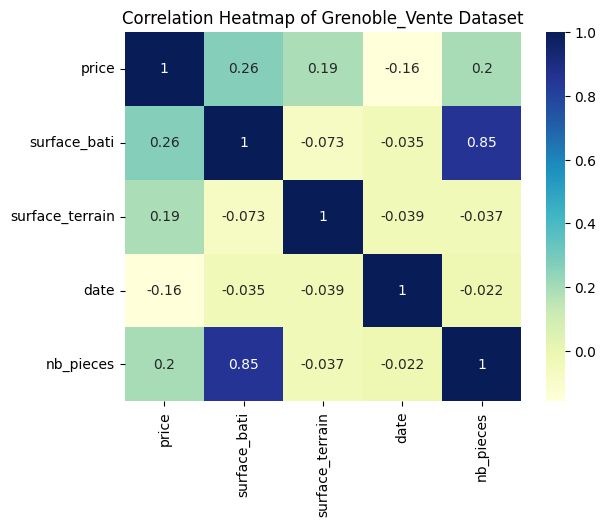

In [19]:
# Compute correlation matrix
corr = df_appartement.corr(numeric_only=True)

# Plot
sns.heatmap(corr, annot=True, cmap="YlGnBu")

plt.title("Correlation Heatmap of Grenoble_Vente Dataset")
# la correlation date/price est plus que celle entre nb_piece/price en valeur absolue donc en la garde
plt.show()

## 6. Transformations logarithmiques
Construction des variables en log pour un modèle hédonique multiplicatif (log-log).

In [22]:
# according to litterature review log(price) ~ log(surface_bati) + log(nb_piece_principale) + date+other variables
# and better if for each category of property type we have a different model
def compute_log_vars(df_in):
    # Keep strictly positive values for log transform
    mask = (df_in['price'] > 0) & (df_in['surface_bati'] > 0) & (df_in['surface_terrain'] > 0)
    df_out = df_in.loc[mask].copy()
    df_out['log_price'] = np.log(df_out['price'])
    df_out['log_surface_bati'] = np.log(df_out['surface_bati'])
    df_out['log_surface_terrain'] = np.log(df_out['surface_terrain'])
    # Also keep a duplicate name for any legacy cells using 'log_price'
    drop_cols = ['price', 'surface_bati', 'surface_terrain', 'type_local']
    df_out = df_out.drop(columns=drop_cols, errors='ignore')

    return df_out


In [23]:
df_appartement_log = compute_log_vars(df_appartement)
df_appartement_log.head()

,date,nb_pieces,log_price,log_surface_bati,log_surface_terrain
0,10,2,11.631242,3.806662,0.0
1,8,1,11.082143,3.367296,0.0
3,7,2,11.798104,3.891820,0.0
4,3,1,10.878047,2.639057,0.0
5,2,4,11.225243,4.110874,0.0


In [24]:
df_copy_log = compute_log_vars(df_copy)
df_copy_log.head()

,date,nb_pieces,log_price,log_surface_bati,log_surface_terrain
0,10,2,11.631242,3.806662,0.0
1,8,1,11.082143,3.367296,0.0
3,7,2,11.798104,3.891820,0.0
4,3,1,10.878047,2.639057,0.0
5,2,4,11.225243,4.110874,0.0


## 7. Standardisation (z-score)
Mise à l'échelle des variables numériques pour comparer les coefficients.

In [25]:
def standard_scale_df(df, return_scaler=False):
    """
    Returns a copy of df with all numeric columns standard-scaled (mean=0, std=1).

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    return_scaler : bool, optional (default=False)
        If True, also returns the fitted StandardScaler object.

    Returns
    -------
    df_scaled : pd.DataFrame
        DataFrame with same columns, numeric ones scaled, non-numeric unchanged.
    (optional) scaler : sklearn.preprocessing.StandardScaler
        Fitted scaler, useful for transforming new data later.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        print("No numeric columns found; returning original DataFrame.")
        return (df.copy(), None) if return_scaler else df.copy()

    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

    return (df_scaled, scaler) if return_scaler else df_scaled


## 8. Jeux de données dérivés
Création des versions raw/log/scaled et assemblage dans un dictionnaire pour itérer les modèles.

In [32]:
# Scaled versions and dictionary of datasets
df_appartementScaled = standard_scale_df(df_appartement)
df_appartementScaled_log = standard_scale_df(df_appartement_log)
df_copyScaled = standard_scale_df(df_copy)
df_copyScaled_log = standard_scale_df(df_copy_log)

# Use a dictionary instead of a list and adapt downstream code
datasets = {
    "raw_appartement": df_appartement,
    "raw_appartement_log": df_appartement_log,
    "raw_all": df_copy,
    "raw_all_log": df_copy_log,
    "scaled_appartement": df_appartementScaled,
    "scaled_appartement_log": df_appartementScaled_log,
    "scaled_all": df_copyScaled,
    "scaled_all_log": df_copyScaled_log,
}

## 9. Modélisation OLS (formule) et métriques
Ajustement de modèles OLS pour chaque dataset et calcul des métriques en échantillon (R², RMSE).

In [40]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error

# Fit OLS models for each prepared dataset
models = {}
metrics = {}

for name, df_in in datasets.items():
    df = df_in.copy()
    # Make all column names formula-safe
    df.columns = df.columns.str.replace('[^0-9a-zA-Z_]+', '_', regex=True)

    target = 'log_price' if 'log_price' in df.columns else 'price'
    if target not in df.columns:
        print(f"Skipping {name}: target not found")
        continue

    predictors = [c for c in df.columns if c != target]
    formula = f"{target} ~ " + " + ".join(predictors)

    model = smf.ols(formula=formula, data=df).fit()
    models[name] = model

    # In-sample metrics
    y_true = df[target]
    y_pred = model.predict(df)
    r2 = r2_score(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    metrics[name] = {
        "formula": formula,
        "target": target,
        "r2": float(r2),
        "rmse": rmse,
        "n_obs": int(len(df)),
        "predictors": predictors,
    }

    print(f"\n=== {name} ===")
    print(formula)
    print(model.summary().as_text())
    print(f"R2={r2:.3f} RMSE={rmse:.3f})")


=== raw_appartement ===
price ~ surface_bati + surface_terrain + date + nb_pieces
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     41.70
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           1.71e-32
Time:                        15:14:52   Log-Likelihood:                -14130.
No. Observations:                1062   AIC:                         2.827e+04
Df Residuals:                    1057   BIC:                         2.829e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

## 10. Visualisation: observé vs prédit et importance des variables
Graphiques de performance (échelle prix) et importance (|t|-stat ou bêta standardisés).

/tmp/ipykernel_4887/3405111126.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  imp = [(n, abs(float(tvals[i]))) for i, n in enumerate(names)


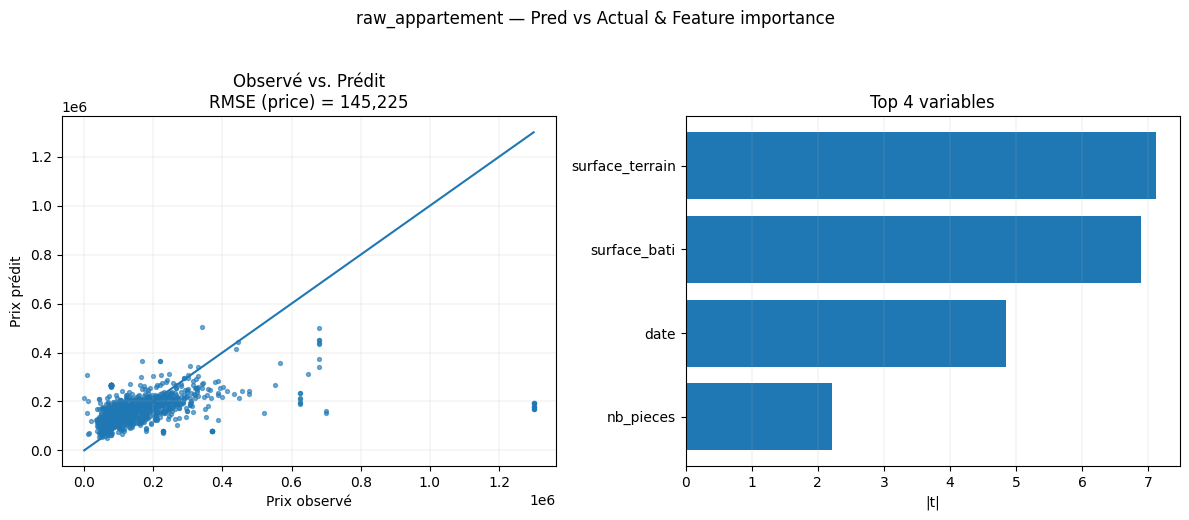

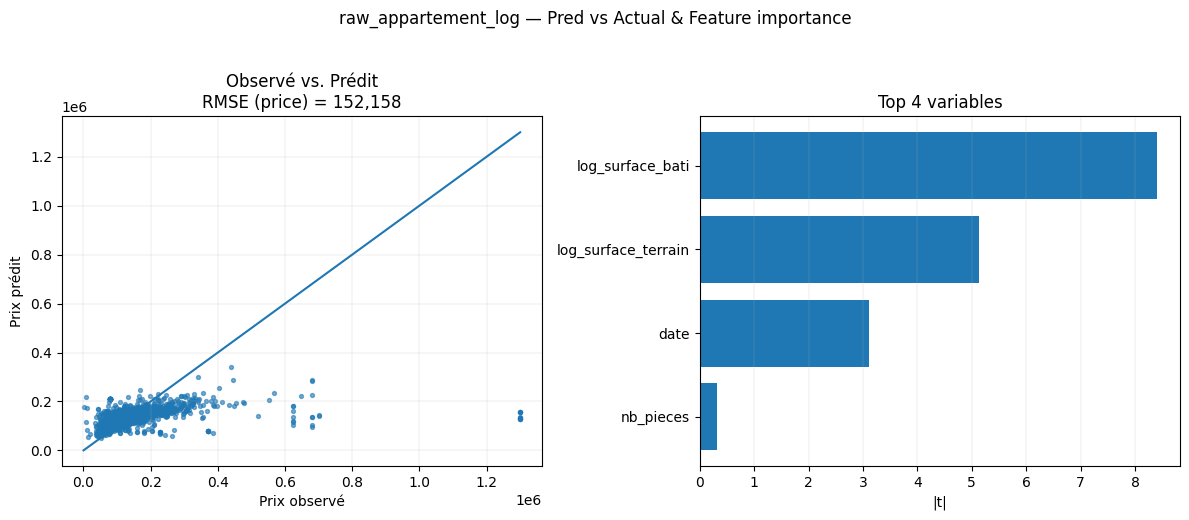

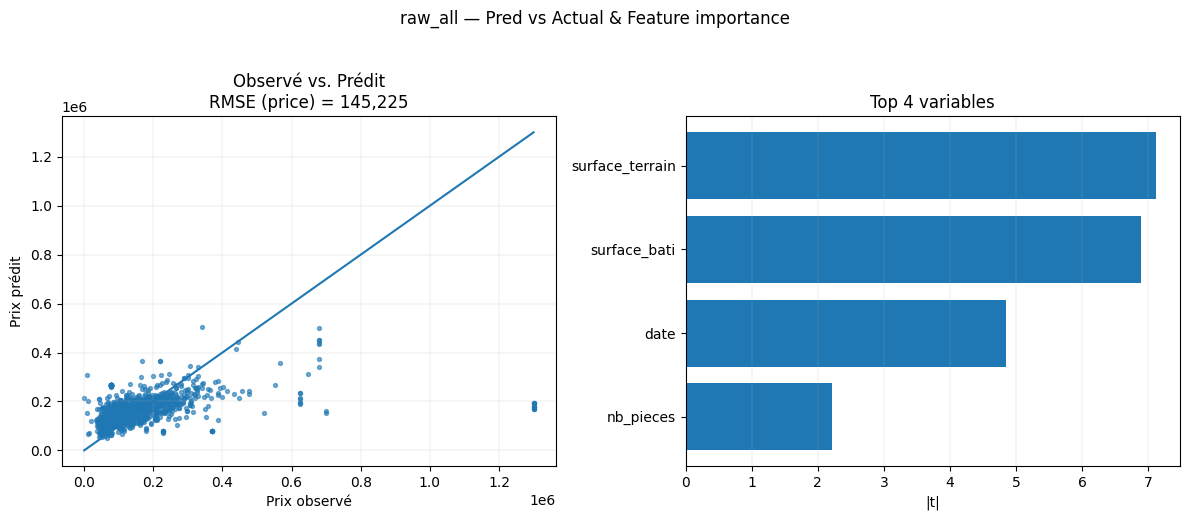

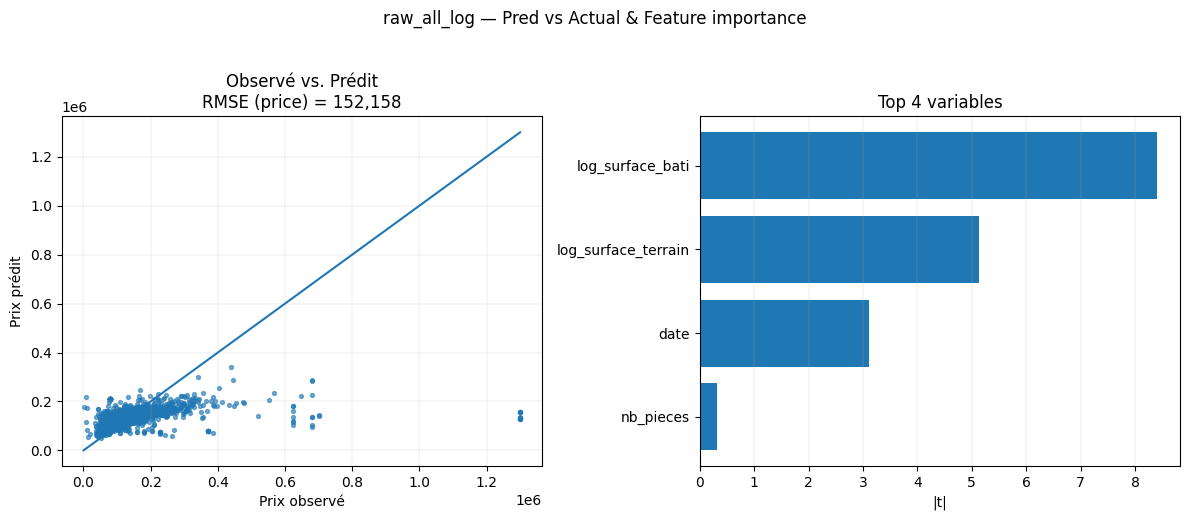

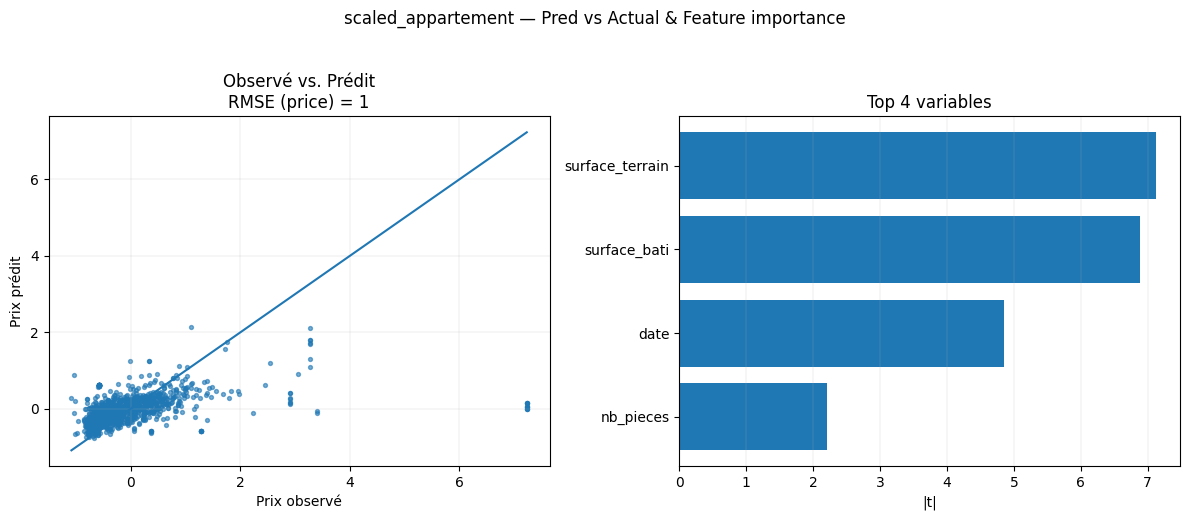

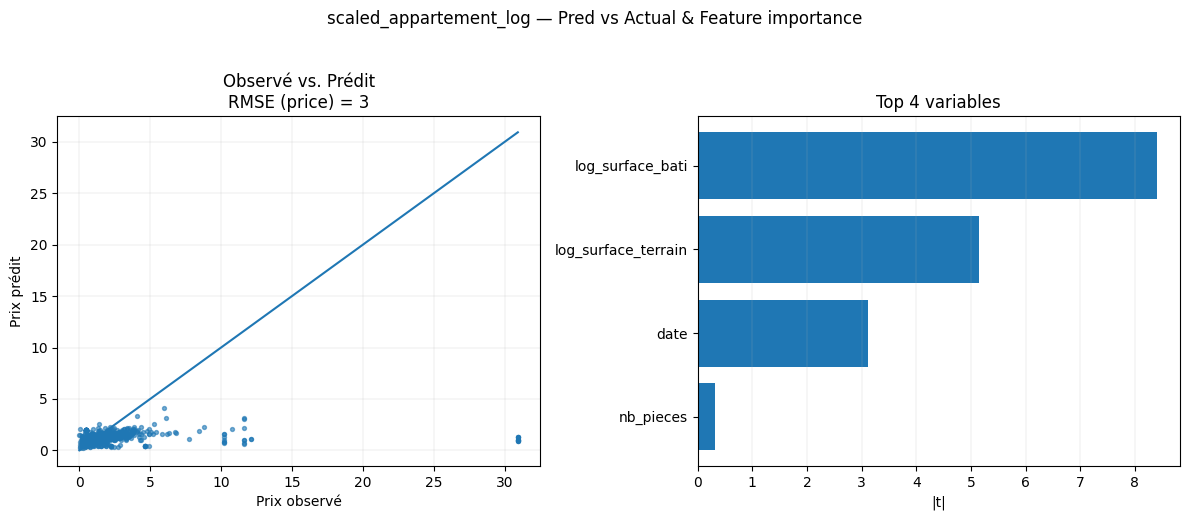

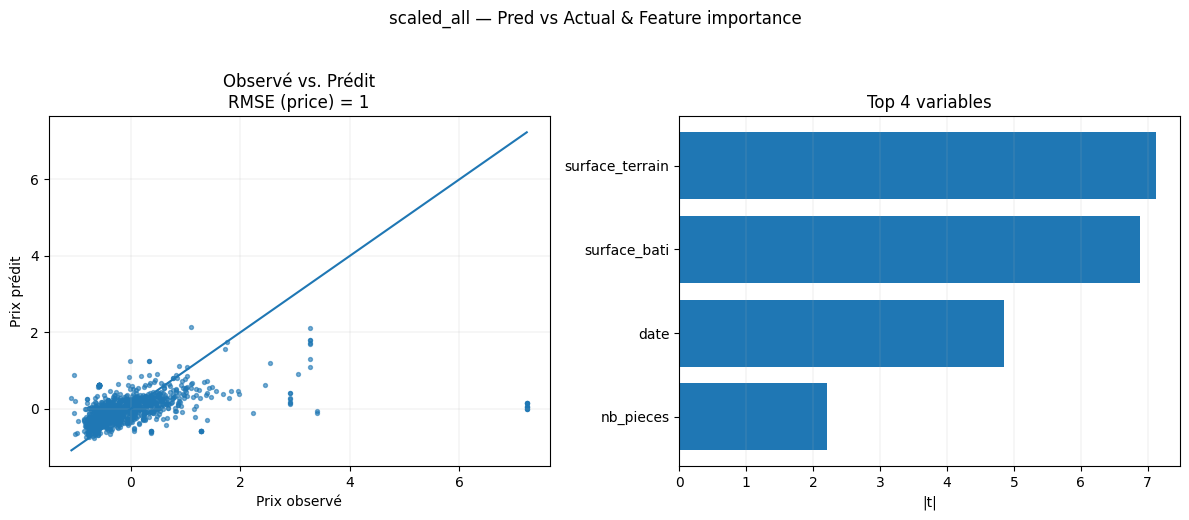

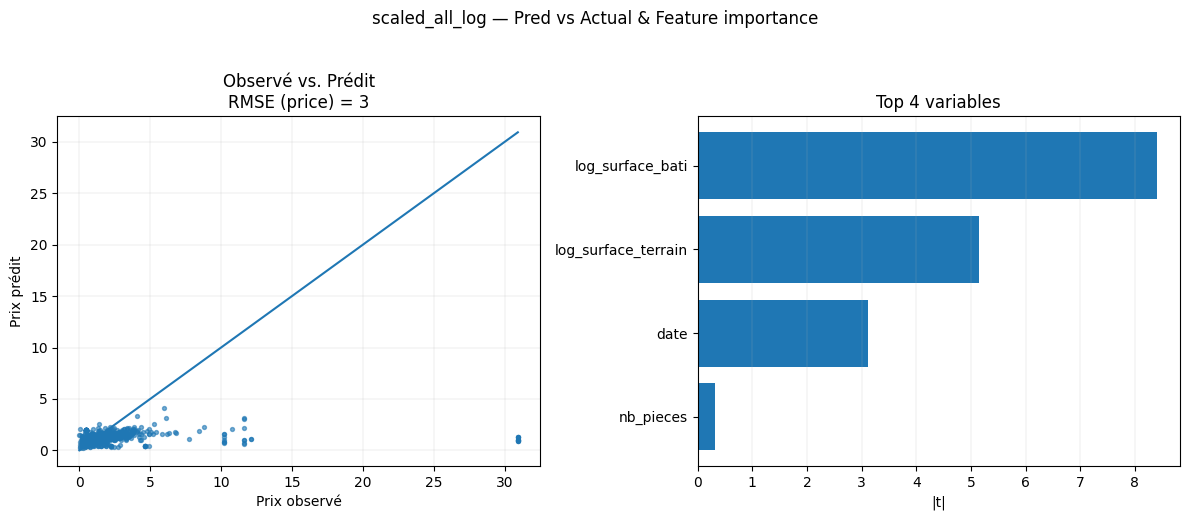

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def _price_scale(y, target_name):
    """Retourne y en unités 'price' (passe de log_price à price si besoin)."""
    if 'log_price' in target_name.lower():
        return np.exp(y)  # suppose un log naturel
    return y

def _std_betas(model):
    """
    Coefs standardisés (beta_j = coef_j * sd(X_j) / sd(y)).
    Intercept exclu.
    """
    y = model.model.endog
    X = model.model.exog
    names = model.model.exog_names
    params = model.params

    # indices sans intercept
    keep = [i for i,n in enumerate(names) if n.lower() not in ['intercept','const']]
    Xk = X[:, keep]
    names_k = [names[i] for i in keep]
    params_k = np.array([params[i] for i in keep])

    sd_y = np.std(y, ddof=0)
    sd_X = np.std(Xk, axis=0, ddof=0)
    # éviter division par zéro
    sd_X = np.where(sd_X==0, 1.0, sd_X)

    betas = params_k * sd_X / (sd_y if sd_y != 0 else 1.0)
    return names_k, betas

def plot_preds_and_importance(models, metrics, top_k=12, importance="tstat"):
    """
    importance: "tstat" (|t|), "beta" (coeffs standardisés).
    """
    for name, model in models.items():
        # Récup cibles/prédictions à l'échelle 'price'
        # On devine le nom de la cible à partir de la formule stockée dans metrics[name]["formula"]
        formula = metrics.get(name, {}).get("formula", "")
        target_name = formula.split("~")[0].strip() if "~" in formula else "price"
        y_true_raw = model.model.endog
        y_pred_raw = model.fittedvalues

        y_true_price = _price_scale(y_true_raw, target_name)
        y_pred_price = _price_scale(y_pred_raw, target_name)

        # Calcul d'un RMSE en unités "price"
        rmse_price = float(np.sqrt(np.mean((y_true_price - y_pred_price) ** 2)))

        # ----- Importance des variables -----
        if importance == "tstat":
            # |t| sans intercept
            tvals = model.tvalues
            names = model.model.exog_names
            imp = [(n, abs(float(tvals[i]))) for i, n in enumerate(names)
                   if n.lower() not in ['intercept','const']]
        elif importance == "beta":
            names_k, betas = _std_betas(model)
            imp = list(zip(names_k, np.abs(betas)))
        else:
            raise ValueError("importance must be 'tstat' or 'beta'")

        # top-k
        imp_sorted = sorted(imp, key=lambda x: x[1], reverse=True)[:top_k]
        feat_names = [n for n,_ in imp_sorted][::-1]  # pour barh: du bas vers le haut
        feat_scores = [s for _,s in imp_sorted][::-1]

        # ----- Plot -----
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(f"{name} — Pred vs Actual & Feature importance", fontsize=12, y=1.03)

        # (1) Observé vs Prédit (échelle price)
        ax = axes[0]
        ax.scatter(y_true_price, y_pred_price, s=8, alpha=0.6)
        # diagonale
        lo = float(np.min([y_true_price.min(), y_pred_price.min()]))
        hi = float(np.max([y_true_price.max(), y_pred_price.max()]))
        ax.plot([lo, hi], [lo, hi])
        ax.set_xlabel("Prix observé")
        ax.set_ylabel("Prix prédit")
        ax.set_title(f"Observé vs. Prédit\nRMSE (price) = {rmse_price:,.0f}")
        ax.grid(True, linewidth=0.3, alpha=0.5)

        # (2) Importance des variables
        ax2 = axes[1]
        ax2.barh(feat_names, feat_scores)
        lab = "|t|" if importance == "tstat" else "|β standardisé|"
        ax2.set_xlabel(lab)
        ax2.set_title(f"Top {len(feat_names)} variables")
        ax2.grid(axis='x', linewidth=0.3, alpha=0.5)

        plt.tight_layout()
        plt.show()

# --- Utilisation ---
# Après avoir rempli `models` et `metrics` avec ton code :
# Plot avec importance basée sur |t-stat|
plot_preds_and_importance(models, metrics, top_k=12, importance="tstat")

# Variante : importance via coefficients standardisés
# plot_preds_and_importance(models, metrics, top_k=12, importance="beta")


## 11. Conclusion
Le notebook met en place une chaîne OLS: préparation des données, variantes log/scaled, ajustement multi-datasets, et diagnostics graphiques.